# Image Color Segmentation


### Goal
The goal of the project is to create a **tool** which is able to segment images by color, and further report the top three colors present in the images along with their densities. Additionally, It also identifies these colurs by their name

### Some Applications
This tool can potentially find application across a wide array of use cases -  from automating the filling in the decsription/ color details in a product catalogs (or in an e-commerce page) or to perform a visual analysis of brand logos or corporate communication to more outside the box ideas like identifying the forest cover in landscape images.

### Underlying Logic / Algorithm
The pixels of the image are clustered into groups based on their RGB values. The cluster centroids (centers) are the average intensities of prominent colors. This point will be clearer looking at some of the examples below.

The underlying algorithm is a version of `KMeans` called `KMeans++` ([more info.](https://dl.acm.org/citation.cfm?id=2180915)). `KMeans++` converges better than the regular `KMeans` algorithm.


### Implementation Notes
1. It is recommended to scale the data to implement any clustering algorithm. Since RGB values are of the same scale, 0-255, no scaling has been performed
2. The image formats are typically `(x,y,3)` which is a three-dimensional matrix with the first two dimensions comprising the length and the width, while the third dimension has the RGB intensities of the pixels. At times there is the 4th dimension as well, this corresponds to an `alpha channel` which denotes either transparency (e.g. in logos) or any additional information that is encoded in the images. 
3. `webcolors` is a very useful library that converts RGB values to color names. It has an expanded list of colors like *sienna* , which by the way is close to *rust color*.


### References
1. [Machine Learning and Deep Learning](https://github.com/ageron/handson-ml2)
2. [matching a given (RGB) to the closest color in the palette](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python)
3. This notebook is placed in [this folder](https://github.com/raamav/ML_Projects_git)

PS: In case if you have any queries regarding this notebook, please reach out to me at `raama (dot) v (at) gmail`

In [4]:
#Importing standard packages and utilities

import sklearn
import numpy as np
import os

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

#create the reqired folders if they don't already exist
os.makedirs(IMAGES_PATH, exist_ok=True)

# a utility that makes saving images much, much easier 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    

In [5]:
#importing packages that help read images

from matplotlib.image import imread
import imageio

shape of the image: (365, 500, 4)


(-0.5, 499.5, 364.5, -0.5)

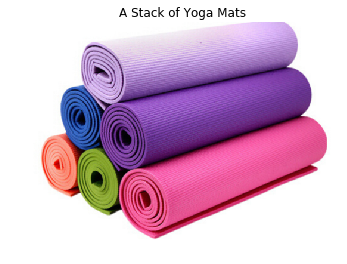

In [102]:
#importing the images
image = imageio.imread(os.path.join("images","unsupervised_learning","Yoga-mats.png"))

print("shape of the image:" , image.shape) # The 4th dimension is the alpha factor corresponding to transparency

plt.title('A Stack of Yoga Mats')
plt.imshow(image)
plt.axis('off')

The next step is to **prepare the data** for clustering. The image is reshaped in a way that all the pixels are along the rows which their RGB and alpha intensities are along the columns.

So, it is a `m * 4` matrix where m referes to the total number of pixels in the image which is equal to the `length * width` of image

In [103]:
X = image.reshape(-1,4)
X.shape

(182500, 4)

The next step is to run `KMeans++` with `7` clusters, we are choosing exactly 7 clusters as there are 7 colors in the image (in a general scenario, `k`, the number of clusters can be fixed at 10) 

In [104]:
#running k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 7, random_state = 42) # there are 7 colors in the image inclusing the white color

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

The next step is to examine the **cluster centroids**, there are seven centroids corresponding to each of the seven clusters

These numbers don't make sense as these represent pixel `RGB-alpha` values. 

In [105]:
cluster_centers =  kmeans.cluster_centers_
cluster_centers

array([[211.18118208, 179.36538563, 228.72589451, 255.        ],
       [ 97.36191242,  56.15726162, 143.30670804, 255.        ],
       [131.03912079, 158.16031458,  46.51603146, 255.        ],
       [253.49227709, 252.72085265, 253.44711053, 255.        ],
       [146.27415053,  94.83904583, 186.2229356 , 255.        ],
       [ 67.99913892,  15.18735649,  42.05202354, 255.        ],
       [234.69954498,  91.87495145, 146.74210643, 255.        ]])

The **4th column** contains the variable that controls the transparency of images (hence all the rows have a constant value of 255), the next step is to get rid of this as it doesn't contribute to the color segmentation 

In [106]:
cluster_centers = cluster_centers[:,0:3]
cluster_centers.shape

(7, 3)

So, *great*, we have a set of the 7 clusters which should ideally represent the **Top 7 colors** of the image, plotting these colors

(7, 1, 3)
Saving figure color_map_yoga_mat


(-0.5, 0.5, 6.5, -0.5)

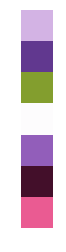

In [107]:
# Data manupulation step to ensure compatibility with imhow command
cluster_centers = cluster_centers.reshape(-1,1,3)

# valiating if the resape operation works
print(cluster_centers.shape)

# finally ploting the image and saving it using the 'save_fig' function defined earlier
plt.imshow(cluster_centers/255)
save_fig('color_map_yoga_mat', tight_layout=False)
plt.axis('off')


This looks great, these are indeed the 7 colors that were a part of the image.
The **next step** is get the densities of these colors to identify the **top colors**. 

Saving figure Top 3 Colors - Yogamat 


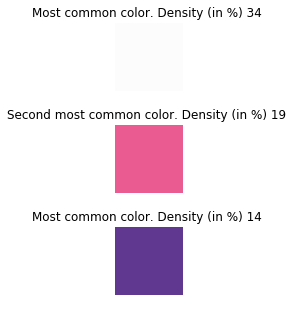

In [126]:
from collections import Counter, defaultdict

d = Counter(kmeans.labels_)
type(d)

max_val = 0
max_color = 0
second_max_val = 0
second_max_color = 0
third_max_val = 0
third_max_color = 0

m = X.shape[0]
#no_clusters = k

for i in d.keys():
    #print(i)
    if d[i] > max_val:
        max_val = d[i]
        max_color = i

for j in d.keys():
    if j == max_color:
        continue
    if d[j] > second_max_val:
        second_max_val = d[j]
        second_max_color = j

for p in d.keys():
    if p == max_color or p == second_max_color :
        continue
    if d[p] > third_max_val:
        third_max_val = d[p]
        third_max_color = p

d_max_color = int((d[max_color])*100/m)
d_second_max_color = int((d[second_max_color])*100/m)
d_third_max_color = int((d[third_max_color])*100/m)

#plotting the three images 

plt.figure(figsize = (5,5))
plt.subplots_adjust(wspace=0.05, hspace=0.5)

#first
plt.subplot(3,1,1)
plt.axis('off')
plt.title("Most common color. Density (in %) {} ".format(d_max_color))
plt.imshow(cluster_centers[max_color].reshape(1,1,3)/255) 

#second
plt.subplot(3,1,2)
plt.axis('off')
plt.title("Second most common color. Density (in %) {} ".format(d_second_max_color))
plt.imshow(cluster_centers[second_max_color].reshape(1,1,3)/255) 

#third
plt.subplot(3,1,3)
plt.axis('off')
plt.title("Most common color. Density (in %) {} ".format(d_third_max_color))
plt.imshow(cluster_centers[third_max_color].reshape(1,1,3)/255) 



save_fig('Top 3 Colors - Yogamat ', tight_layout=False)

Now have the **Top three colors** and their densities, let us also get the **names of these colors** using the `webcolors` library

Starting off by creating a function that takes in the RGB values and gives the name of the closest color that matches with the specified values. For more details, refer to this [excellent post](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python) in StackOverFlow  

In [128]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name


There is some typecasting involved as the above function accepts **tuples** while the centroids are in **numpy array** format. 
The next step combines this data preperation/manupulation and the function call

In [129]:
#inefficient code - needs to be optimised

max_color_l = []
for i in np.nditer(cluster_centers[max_color]):
    max_color_l.append(i)
    max_color_t = tuple(max_color_l)

sec_max_color_l = []
for i in np.nditer(cluster_centers[second_max_color]):
    sec_max_color_l.append(i)
    sec_max_color_t = tuple(sec_max_color_l)

th_max_color_l = []
for i in np.nditer(cluster_centers[third_max_color]):
    th_max_color_l.append(i)
    th_max_color_t = tuple(th_max_color_l)


The next and the **last step** is to generate the names of these top 3 colors

In [131]:
print ("The color with the highest density is",get_colour_name(max_color_t) )

print ("The color with the second highest density is",get_colour_name(sec_max_color_t) )

print ("The color with the third highest density is",get_colour_name(th_max_color_t) )

The color with the highest density is white
The color with the second highest density is palevioletred
The color with the third highest density is darkslateblue


***

The next step gives an **iterative demonstration** of the algorithm

Saving figure image_segmentation_diagram_yoga_mat


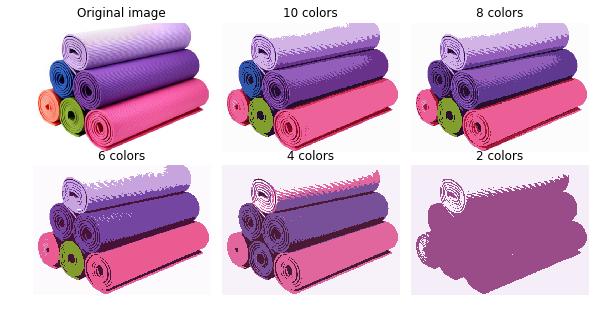

In [100]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans2 = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans2.cluster_centers_[kmeans2.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx]/255)
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram_yoga_mat', tight_layout=False)
plt.show()

The above diagram demonstrates how the colors merge as the number of clusters reduces.

***


*Thanks for reading. Please write to me at `raama (dot) v (at) gmail` if you have any feedback*